## Latitude, Longitude, and Year

In order to attempt to find relationships between artist location and year, with the hope of identifying clusters pointing to musical hotspots at times they were most active, as well as the way these locations may change over time.

Beginning with the basic setup and imports:

In [1]:
import pandas as pd
import numpy as np
import pickle

import sys, os
tim_path = 'C:\\Users\\Tim\\PycharmProjects\\625.687\src'
ben_path = '/Users/ben/Documents/625.687/src'

if os.path.exists(tim_path):
    sys.path.append(tim_path) # your local repo here
elif os.path.exists(ben_path):
    sys.path.append(ben_path)
else:
    print("Problem accessing src directory.")

try:
    path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe.pkl" # your local data here
    df = pickle.load(open(path, "rb"))
except:
    path = ben_path + "/MillionSongSubset_dataframe.track_id_year_artist_longitude_artist_latitude.pkl"
    df = pickle.load(open(path, "rb"))
#for c in sorted(df.columns):
#    print(c)

Now, some data cleaning:

In [2]:
import msd_utils

# Set up dataframe 
subdf = df[["year", "artist_latitude", "artist_longitude"]]
subdf = subdf.dropna()
subdf = subdf[subdf["year"] != 0]

print(len(subdf))

Finally, building the distance matrix using our metric `year_lat_lon`, stored in `Metrics.py`.

In [3]:
import Metrics

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        try:
            score = mf.year_lat_lon(row1, row2)
            metric_scores.append(score)
        except:
            print(row1)
            print(row2)
    metrics_df.append(metric_scores)

dmatrix = np.array(metrics_df)

Now that we have our distance metric, we can compute the persistence diagram for $H_1$, $H_2$, and $H_3$.

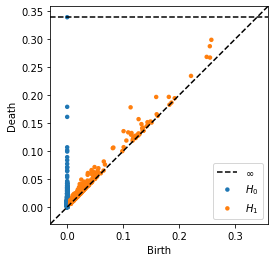

In [5]:
from ripser import ripser
from persim import plot_diagrams

res = ripser(dmatrix, distance_matrix=True, maxdim=2)
plot_diagrams(res['dgms'], show=True)